In [1]:
# %load /home/jonathan/.ipython/profile_default/startup/startup-01.py
# start up settings for ipython
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys

plt.style.use('ggplot')
plt.rcParams['font.size'] = 15.0
plt.rcParams['axes.labelsize'] = 15.0
plt.rcParams['xtick.labelsize'] = 15.0
plt.rcParams['ytick.labelsize'] = 15.0
plt.rcParams['legend.fontsize'] = 15.0

%matplotlib inline

# set the max column width
pd.options.display.max_colwidth = 1000
pd.options.mode.chained_assignment = None 

In [2]:
import functools as fcts

# Tender sale as quality criteria
~20% of the tenders are deserted for various reasons, e.g., no offers. This means ~3000 tenders and ~7000 tender products are not sold. However, what happens to the deserted tenders? Investigation shows that public organizations actually can republish the same tender. As such, $\textit{tender traces}$ can occur where each item of the tender trace is an individual tender. Some trace actually ends with a tender that is sold. 
For example: (example where tender trace ends with a sold tender, explain that the company who bid could not have been created in 18 days)

## Research questions
- What characteristics do traces that end with sold state?
- Does the $\textit{persistence}$ of the related public organizations relate in better sale rate in general?
- Are there external factors, e.g., product type, region, and complaint number, affect the outcome of tender traces?

## Experiment design
- Classification to classify these different types of traces
- Clustering

## Preprocessing
1. Remove columns with >90% null values or 0 variance
2. Remove tenders with 1 tender product
3. Get deserted tenders
4. Do not consider tenders related to hospital and health because of granularity issues, many times there are such big variances in product of the same product code that make it difficult to differentiate one tender product from other without looking into the contract.
5. For all the deserted tenders, find similar tenders by the tender name and organization.
6. Filter tender traces by validating the tender products and tender publication and close dates

In [3]:
tender_df = pd.read_csv('../../data/processed14Nov/tsmall.csv')
tprod_df = pd.read_csv('../../data/processed14Nov/tsprod.csv')

In [4]:
tall_df = tprod_df.merge(tender_df, on='CodigoExterno')

In [6]:
tprod_df.shape

(63116, 13)

## Getting the deserted tender traces of length > 1

### Get deserted tenders

In [5]:
tdesert_df = tender_df[
    (tender_df['Estado'].str.lower().str.startswith('desier'))
]
tdesert_tids = tdesert_df['CodigoExterno'].values
tdprod_df = tprod_df[(tprod_df['CodigoExterno'].isin(tdesert_tids))]
desert_df = tdprod_df.merge(tdesert_df, on='CodigoExterno')

In [6]:
# the following organizations have low quality description in their tenders, basically they use the same tender name 
# for the majority of their tenders
excl_org_code = [7326, 87901]
# some examples that did not make sense and therefore excluded
excl_tid = ['3928-78-L116', '3928-82-L116', '3477-236-L116', '3477-241-L116',
           '2409-878-L116', '2409-910-L116']

deserted = tdesert_df[
    ~(tdesert_df['CompradorCodigoOrganismo'].isin(excl_org_code))&
    ~(tdesert_df['CompradorNombreOrganismo'].str.lower().str.startswith('hospital'))&
    ~(tdesert_df['CompradorNombreOrganismo'].str.lower().str.contains('salud'))&
    ~(tdesert_df['CodigoExterno'].isin(excl_tid))
][['CodigoExterno', 'Nombre', 'FechasFechaPublicacion', 'FechasFechaCierre', 'CompradorCodigoOrganismo']].sort_values('FechasFechaPublicacion')

similar_df = pd.DataFrame()
checked = list()
for td in deserted.itertuples():
    if [td.CompradorCodigoOrganismo, td.Nombre] in checked:
        continue
    checked.append([td.CompradorCodigoOrganismo, td.Nombre])
    similar = tender_df[
        (tender_df['CompradorCodigoOrganismo']==td.CompradorCodigoOrganismo)&
        (tender_df['Nombre']==td.Nombre)
    ].sort_values('FechasFechaPublicacion')[['Estado', 'FechasFechaPublicacion', 'FechasFechaCierre', 'Nombre',
                                             'CompradorNombreOrganismo', 'CompradorCodigoOrganismo', 'AdjudicacionUrlActa', 'CodigoExterno']]
    if similar_df.empty:
        similar_df = similar
    else:
        similar_df = pd.concat([similar_df, similar], axis=0)
    

### Consider only traces with length > 1 and ensure validity

In [7]:
tender_df[(tender_df['Estado'].str.lower().str.startswith('desi'))].shape

(598, 68)

In [8]:
trace_spec = similar_df.groupby('Nombre').size()
print('Total deserted: {}\nTotal traces > 1: {}'.format(trace_spec[trace_spec == 1].shape, 
                                                        trace_spec[trace_spec > 1].shape))
trace_spec = trace_spec[trace_spec > 1].index.values

trace_row_df = similar_df[(similar_df['Nombre'].isin(trace_spec))]

Total deserted: (427,)
Total traces > 1: (35,)


In [9]:
def valid_dates(group, tids):
    # check dates
    last = None
    for tid in tids:
        if last is None:
            last = group[(group['CodigoExterno']==tid)][['FechasFechaPublicacion', 'FechasFechaCierre']].values[0]
        else:
            # check date
            now = group[(group['CodigoExterno']==tid)][['FechasFechaPublicacion', 'FechasFechaCierre']].values[0]
            if pd.to_datetime(now[0]) < pd.to_datetime(last[1]):
                # the publication date is smaller than the close date of the last tender
                return False
            last = now
    return True

def valid_tprods(group, tids):
    prod_dict = dict()
    for tid in tids:
        tprods = tprod_df[(tprod_df['CodigoExterno']==tid)]['CodigoProducto'].values
        tprods.sort()
        prod_dict[tid] = tprods
    # zip them
    for item_tuple in zip(*list(prod_dict.values())):
        if len(set(item_tuple)) > 1:
            return False
    return True

In [10]:
non_comply = list()
for name, group in trace_row_df.groupby('Nombre'):
    tids = group['CodigoExterno'].values
    # check dates
    if not valid_dates(group, tids):
        non_comply.append(tids)
        continue
    # check products
    if not valid_tprods(group, tids):
        non_comply.append(tids)
        continue

non_comply = fcts.reduce(lambda x, y: np.concatenate((x, y)), non_comply)
trace_row_df = trace_row_df[~(trace_row_df['CodigoExterno'].isin(non_comply))]

### Distribution across regions

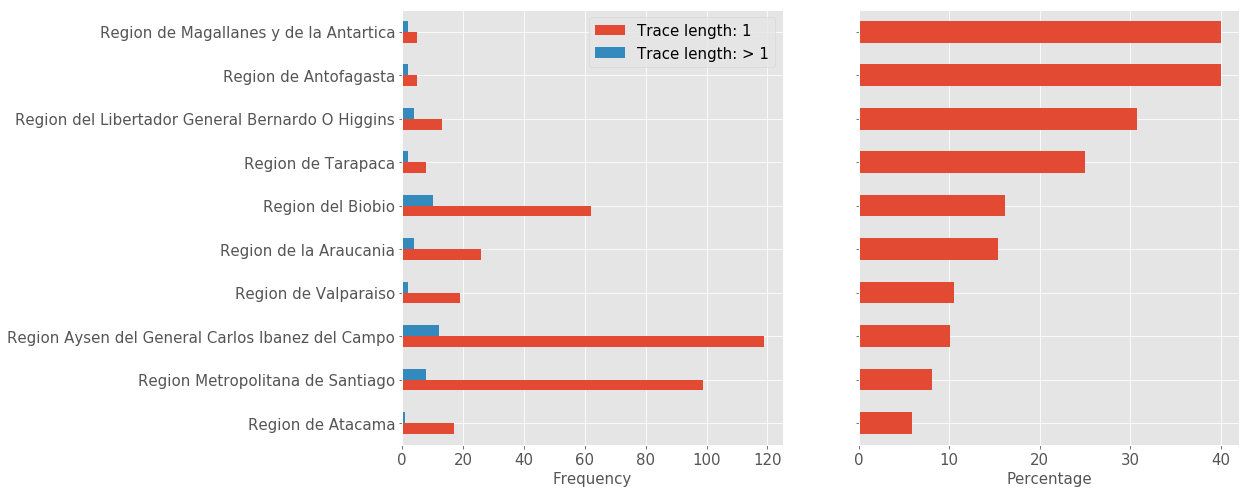

In [11]:
grouped_before = tender_df[(tender_df['CodigoExterno'].isin(deserted['CodigoExterno']))].groupby('CompradorRegionUnidad').size()
grouped_after = tender_df[(tender_df['CodigoExterno'].isin(trace_row_df['CodigoExterno']))].groupby('CompradorRegionUnidad').size()

grouped_before = grouped_before.to_frame().reset_index()
grouped_after = grouped_after.to_frame().reset_index()
grouped = grouped_before.merge(grouped_after, on='CompradorRegionUnidad')
grouped.columns = ['CompradorRegionUnidad', 'Trace length: 1', 'Trace length: > 1']
grouped['perc'] = grouped['Trace length: > 1'] / grouped['Trace length: 1'] * 100
grouped.sort_values('perc', inplace=True, ascending=True)

fig, axes = plt.subplots(figsize=(15, 8), ncols=2)
grouped[['CompradorRegionUnidad', 'Trace length: 1', 'Trace length: > 1']].plot(kind='barh', ax=axes[0]);
axes[0].set_yticklabels(grouped['CompradorRegionUnidad'])
axes[0].set_xlabel('Frequency')
# axes[0].set_title('Distribution across regions with respect to tender trace length of deserted tenders', fontsize=20);

grouped[['CompradorRegionUnidad', 'perc']].plot(kind='barh', ax=axes[1], legend=None);
axes[1].set_yticklabels([])
axes[1].set_xlabel('Percentage');

We can see that Region Biobio tend to be more persistent relatively as more of the deserted tenders in this region are republished. Next we would like to know how likely is a deserted tender going to revive.

### General observations

In [12]:
grouped_state = trace_row_df.groupby('Nombre').apply(lambda x: 'Adjudicada' in x['Estado'].values)
revival_rate = (grouped_state.sum() / grouped_state.shape)[0]
print('Revival rate: {:.2f}% ({}/{})'.format(revival_rate, grouped_state.sum(), grouped_state.shape[0]))

Revival rate: 0.52% (12/23)


This is quite incredible, 67% of the ones that republished the same tender gets sold.

### Distribution in terms of product category

In [13]:
grouped_cat = tprod_df[
    (tprod_df['CodigoExterno'].isin(trace_row_df['CodigoExterno'].values))
].groupby('Categoria').size().to_frame().reset_index()

grouped_cat.columns = ['Categoria', 'count']
grouped_cat.sort_values('count', inplace=True, ascending=False)
grouped_cat.reset_index(drop=True, inplace=True)

grouped_cat.head()

,Categoria,count
0,Equipamiento y suministros medicos / Productos de rehabilitacion terapia ocupacional y fisica / Equipo y dispositivos para ejercicios de rehabilitacion,21
1,Organizaciones y consultorias politicas demograficas economicas sociales y de administracion publica / Desarrollo social demografico y comunitario / Empleo,16
2,Servicios financieros pensiones y seguros / Seguros y jubilacion / Seguros para estructuras propiedades y bienes,14
3,Equipamiento y suministros medicos / Productos para el cuidado de heridas / Vendas vendajes y productos relacionados,14
4,Servicios de transporte almacenaje y correo / Transporte de pasajeros / Transporte de pasajeros por carretera,12


## Divide to two classes

In [14]:
trace_row_df.to_csv('./traceRows.csv')

In [15]:
grouped_state = trace_row_df.groupby('Nombre').apply(lambda x: int('Adjudicada' in x['Estado'].values))
grouped_state = grouped_state.to_frame().reset_index()
grouped_state.columns = ['Nombre', 'class_sold']

merged = trace_row_df.merge(grouped_state, on='Nombre')
merged[(merged['class_sold']==0)]

,Estado,FechasFechaPublicacion,FechasFechaCierre,Nombre,CompradorNombreOrganismo,CompradorCodigoOrganismo,AdjudicacionUrlActa,CodigoExterno,class_sold
0,Desierta o art 3 o 9 Ley 19 886,2016-11-02T15:18:40.123,2016-11-09T14:00:00,CONTRATO SUMNISTRO ORNAMENTACION,Municipalidad de Los Angeles,87187,http://www.mercadopublico.cl/Procurement/Modules/RFB/StepsProcessAward/PreviewAwardAct.aspx?qs=TD13+O8l6MYqg6Qfk+fFMtgwgtMm+D6zef4LnOpN74s=,2408-1194-L116,0
1,Desierta o art 3 o 9 Ley 19 886,2016-11-15T16:47:47.39,2016-11-21T15:00:00,CONTRATO SUMNISTRO ORNAMENTACION,Municipalidad de Los Angeles,87187,http://www.mercadopublico.cl/Procurement/Modules/RFB/StepsProcessAward/PreviewAwardAct.aspx?qs=qlv6n6adCjee6sre51Bm+s+C1XYWMNiulk+jnJqWnL4=,2408-1323-L116,0
2,Desierta o art 3 o 9 Ley 19 886,2016-11-02T15:23:50.373,2016-11-10T09:00:00,Examen Ocupacional a Personal del Aeropuerto Diego Aracena,Direccion General de Aeronautica Civil,7202,http://www.mercadopublico.cl/Procurement/Modules/RFB/StepsProcessAward/PreviewAwardAct.aspx?qs=HJfcGaPNPX9fLUtNwNIuJVnzatvdmhHFwZl9efRvz+U=,1989-99-L116,0
3,Desierta o art 3 o 9 Ley 19 886,2016-11-23T16:37:08.103,2016-12-01T09:00:00,Examen Ocupacional a Personal del Aeropuerto Diego Aracena,Direccion General de Aeronautica Civil,7202,http://www.mercadopublico.cl/Procurement/Modules/RFB/StepsProcessAward/PreviewAwardAct.aspx?qs=Qn8nkbm19kyaC/lMqhdo9XBRJBMJ0G6q2k62Rth9e/I=,1989-104-CO16,0
8,Desierta o art 3 o 9 Ley 19 886,2016-11-02T19:58:08.873,2016-11-08T17:00:00,ADQUISICION DE DISPENSADOR Y SUMINISTRO DE BOTELLON CFLL,Gobernacion Provincial de Los Andes,7009,http://www.mercadopublico.cl/Procurement/Modules/RFB/StepsProcessAward/PreviewAwardAct.aspx?qs=hioOX1Mlx7fxgeVjF6BZc46O8zxi548ccue8eb6lCns=,92-33-L116,0
9,Desierta o art 3 o 9 Ley 19 886,2016-11-15T10:36:37.26,2016-11-21T15:30:00,ADQUISICION DE DISPENSADOR Y SUMINISTRO DE BOTELLON CFLL,Gobernacion Provincial de Los Andes,7009,http://www.mercadopublico.cl/Procurement/Modules/RFB/StepsProcessAward/PreviewAwardAct.aspx?qs=PDH/SqeJuPRs3TGfhSvm2fUF0tXjLuN/daZs8ZbDxjY=,92-35-L116,0
14,Desierta o art 3 o 9 Ley 19 886,2016-11-04T16:08:26.097,2016-11-10T09:00:00,ARTICULOS PARA CAPITANIA DE PUERTO DE HUASCO,ARMADA DE CHILE,111875,http://www.mercadopublico.cl/Procurement/Modules/RFB/StepsProcessAward/PreviewAwardAct.aspx?qs=4o18JBafabKg+RiWkEXU1sZCpPLRx3sDitedGz/CbWM=,3175-40-L116,0
15,Desierta o art 3 o 9 Ley 19 886,2016-11-15T12:34:49.143,2016-11-21T15:01:00,ARTICULOS PARA CAPITANIA DE PUERTO DE HUASCO,ARMADA DE CHILE,111875,http://www.mercadopublico.cl/Procurement/Modules/RFB/StepsProcessAward/PreviewAwardAct.aspx?qs=vTwOruDLS4IxMBFYrTLWkQqdTwcUCEH3sLYSB4QgHbM=,3175-43-L116,0
20,Desierta o art 3 o 9 Ley 19 886,2016-11-08T11:01:07.777,2016-11-15T21:27:00,PTR N 181 BANDERAS PARA EL CESFAM,MUNICIPALIDAD DE VITACURA,98462,http://www.mercadopublico.cl/Procurement/Modules/RFB/StepsProcessAward/PreviewAwardAct.aspx?qs=aOj1bgz3oWLX68ktbDVRV97TkN6jV1sU9vfKTf6b05I=,2669-174-L116,0
21,Desierta o art 3 o 9 Ley 19 886,2016-11-17T15:18:42.177,2016-11-23T17:12:00,PTR N 181 BANDERAS PARA EL CESFAM,MUNICIPALIDAD DE VITACURA,98462,http://www.mercadopublico.cl/Procurement/Modules/RFB/StepsProcessAward/PreviewAwardAct.aspx?qs=Orp7aoskG+Ge3N9A/i7lS9uamf9tcJo9A4HzwCrt+ik=,2669-183-L116,0


### Revived case
An example where a tender gets revived in a re-publication.

In [16]:
merged[
    (merged['CodigoExterno'].isin(['2401-442-L116', '2401-467-L116']))
]

,Estado,FechasFechaPublicacion,FechasFechaCierre,Nombre,CompradorNombreOrganismo,CompradorCodigoOrganismo,AdjudicacionUrlActa,CodigoExterno,class_sold
4,Desierta o art 3 o 9 Ley 19 886,2016-11-02T15:33:25.95,2016-11-08T12:01:00,MOCHILAS PROYECTO INFANCIA,ILUSTRE MUNICIPALIDAD DE RANCAGUA,87167,http://www.mercadopublico.cl/Procurement/Modules/RFB/StepsProcessAward/PreviewAwardAct.aspx?qs=t27FwHY6GxhIEjFmTlRD6yyYduI7UlEBWC6N4Q0ABXo=,2401-442-L116,1
5,Adjudicada,2016-11-15T17:04:11.183,2016-11-22T12:00:00,MOCHILAS PROYECTO INFANCIA,ILUSTRE MUNICIPALIDAD DE RANCAGUA,87167,http://www.mercadopublico.cl/Procurement/Modules/RFB/StepsProcessAward/PreviewAwardAct.aspx?qs=ckCgGyh5kukvjtTq6rUOy23XxwBsgCyz3x7T4cedS3k=,2401-467-L116,1


### Remains dead
An example where a tender remains deserted in the future re-publication.

In [17]:
merged[
    (merged['CodigoExterno'].isin(['1989-99-L116', '1989-104-CO16']))
]

,Estado,FechasFechaPublicacion,FechasFechaCierre,Nombre,CompradorNombreOrganismo,CompradorCodigoOrganismo,AdjudicacionUrlActa,CodigoExterno,class_sold
2,Desierta o art 3 o 9 Ley 19 886,2016-11-02T15:23:50.373,2016-11-10T09:00:00,Examen Ocupacional a Personal del Aeropuerto Diego Aracena,Direccion General de Aeronautica Civil,7202,http://www.mercadopublico.cl/Procurement/Modules/RFB/StepsProcessAward/PreviewAwardAct.aspx?qs=HJfcGaPNPX9fLUtNwNIuJVnzatvdmhHFwZl9efRvz+U=,1989-99-L116,0
3,Desierta o art 3 o 9 Ley 19 886,2016-11-23T16:37:08.103,2016-12-01T09:00:00,Examen Ocupacional a Personal del Aeropuerto Diego Aracena,Direccion General de Aeronautica Civil,7202,http://www.mercadopublico.cl/Procurement/Modules/RFB/StepsProcessAward/PreviewAwardAct.aspx?qs=Qn8nkbm19kyaC/lMqhdo9XBRJBMJ0G6q2k62Rth9e/I=,1989-104-CO16,0


## Constructing trace df with features

In [18]:
merged.columns

Index(['Estado', 'FechasFechaPublicacion', 'FechasFechaCierre', 'Nombre',
       'CompradorNombreOrganismo', 'CompradorCodigoOrganismo',
       'AdjudicacionUrlActa', 'CodigoExterno', 'class_sold'],
      dtype='object')

In [19]:
# get date data
aux = merged[['Nombre', 'FechasFechaPublicacion', 'FechasFechaCierre']]
aux['FechasFechaPublicacion'] = pd.to_datetime(aux.loc[:,'FechasFechaPublicacion'])
aux['FechasFechaCierre'] = pd.to_datetime(aux.loc[:,'FechasFechaCierre'])
aux['tender_duration'] = aux['FechasFechaCierre'] - aux['FechasFechaPublicacion']

def compute_lapse(tname, df):
    trace = df[(df['Nombre']==tname)]
    last = None
    lapse_list = list()
    for tender in trace.itertuples():
        now = tender
        if last is not None:
            # compute lapse
            lapse_list.append(now.FechasFechaPublicacion - last.FechasFechaCierre)
        last = now
    return np.mean(lapse_list)

def compute_duration(tname, df):
    return df.loc[(df['Nombre']==tname), 'tender_duration'].mean()

def cmp_desc_chg(tname, df):
    trace = df[(df['Nombre']==tname)]
    last = None
    change_list = list()
    for tender in trace.itertuples():
        now = tender
        if last is not None:
            # compute lapse
            change_list.append(len(now.Descripcion_y) - len(last.Descripcion_y))
        last = now
    return np.mean(change_list)
            
trace_df = merged[['Nombre', 'class_sold', 'CompradorCodigoOrganismo', 'CodigoExterno']]
# trace_df = trace_df.drop_duplicates()
trace_df.loc[:,'lapse'] = aux.loc[:,'Nombre'].apply(lambda x: compute_lapse(x, aux))
trace_df['avg_tduration'] = aux.loc[:,'Nombre'].apply(lambda x: compute_duration(x, aux))

# product code, region, average number of words in description, item quantity, reclamos, 
aux = tall_df[['CodigoProducto', 'CompradorRegionUnidad', 'Descripcion_y', 
               'ItemsCantidad', 'CantidadReclamos', 'CodigoExterno']]
aux = aux.drop_duplicates('CodigoExterno')
# trace_df = trace_df.merge(merged[['Nombre', 'CodigoExterno']], on='Nombre')
trace_df = trace_df.merge(aux, on='CodigoExterno')
trace_df['des_len'] = trace_df['Descripcion_y'].apply(len)
trace_df['name_len'] = trace_df['Nombre'].apply(len) 
trace_df['avg_desc_chg'] = trace_df['Nombre'].apply(lambda x: cmp_desc_chg(x, trace_df))
trace_df = trace_df[[colname for colname in trace_df.columns 
                     if not (colname == 'Descripcion_y' or colname == 'CodigoExterno' or colname == 'Nombre') ]]
# convert timedelta columns to hours
trace_df['lapse'] = trace_df['lapse'].dt.components.hours
trace_df['avg_tduration'] = trace_df['avg_tduration'].dt.components.hours


### Convert to numerical

In [20]:
from sklearn import preprocessing

le_dict = dict()
for col in trace_df.columns:
    if np.issubdtype(trace_df[col].dtype, np.number):
        continue
    le = preprocessing.LabelEncoder()
    # fit the labels
    _ = le.fit(trace_df[col])
    # transform the labels
    trace_df[col] = le.transform(trace_df[col])
    # save the labeler
    le_dict[col] = le

### Remove columns that have low variance

In [21]:
var_threshold = .01
for col in trace_df.columns:
    if trace_df[col].var() < var_threshold:
        print('Removing column: {}'.format(col))
        trace_df.drop(col, axis=1, inplace=True)

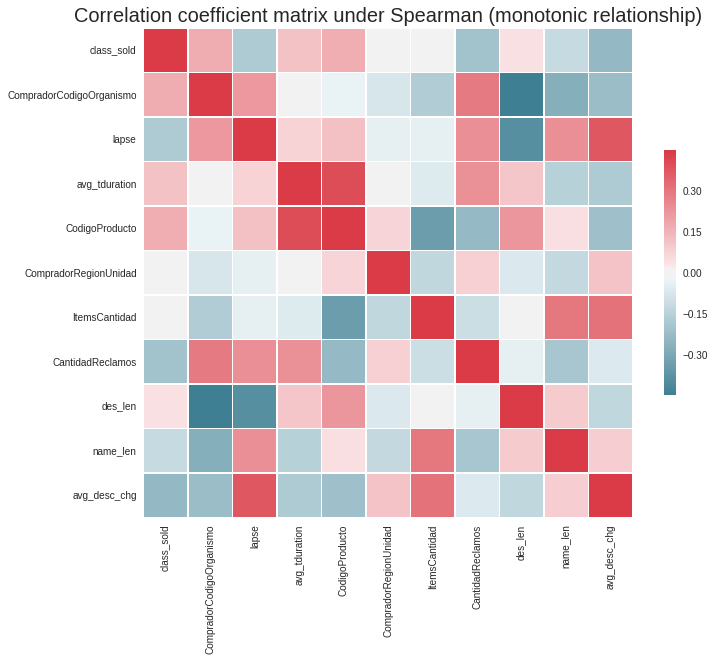

In [22]:
import seaborn as sns

corr = trace_df.corr('spearman')

# set up the matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
               square=True, linewidth=.5, cbar_kws={'shrink': .5})

_ = ax.set_title('Correlation coefficient matrix under Spearman (monotonic relationship)', fontsize=20)

## Evaluate with classifier on class_sold

In [23]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

'''
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]
'''
names = ["Nearest Neighbors", "RBF SVM", 
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
#    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
#    GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

'\nnames = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",\n         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",\n         "Naive Bayes", "QDA"]\n'

### Distribution of class_sold

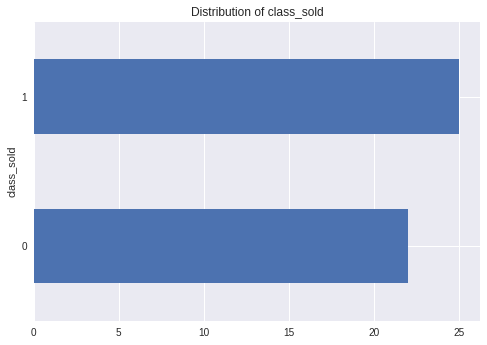

In [24]:
grouped = trace_df.groupby('class_sold').size()
ax = grouped.plot(kind='barh')
ax.set_title('Distribution of class_sold');

Given that the two classes are only slightly unbalanced, there's really no need to oversample, but let's try it anyway.

### Create train and test sets

In [25]:
dataset_y = trace_df['class_sold']
dataset_X = trace_df.drop('class_sold', axis=1)

train_X, test_X, train_y, test_y = train_test_split(dataset_X, dataset_y, test_size=.4, random_state=123)

# there can be overlap between train and test sets where there are instances duplicated in both train and test
# for fairer test, remove those from test
train = pd.concat([train_X, train_y], axis=1)
test = pd.concat([test_X, test_y], axis=1)
before = test.shape[0]

merged = pd.merge(test, train, how='outer', indicator=True)
# select only left_only, i.e., unique test set instances
test_no_dup = merged.loc[merged._merge=='left_only']
test_no_dup.drop('_merge', inplace=True, axis=1)
after = test_no_dup.shape[0]
print('Removed {} rows from test set with original: {}'.format(before - after, before))
print('Removed {:.2f}% of original'.format((before - after) / before * 100))

train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

# oversample train set
grouped = train.groupby('class_sold').size()
to_oversample = int(abs(grouped.diff()[1]))
print('Oversampling {} rows...'.format(to_oversample))
idx = np.random.choice(train.loc[train['class_sold'] == 0].index, size=to_oversample)
train_oversampled = pd.concat([train, train.iloc[idx]])

train_ds_list = [train, train_oversampled]
train_ds_namelist = ['Original', 'Oversampled']

test_ds_list = [test, test_no_dup]
test_ds_namelist = ['Original', 'No duplicates']

Removed 3 rows from test set with original: 19
Removed 15.79% of original
Oversampling 2 rows...


In [26]:
import multiprocessing
from multiprocessing import Queue
import math

In [27]:
# parallelize at the level of classifiers
def mp_classify(train_X, train_y, test_X, test_y, names, classifiers, nprocs):
    def worker(train_X, train_y, test_X, test_y, name_list, clf_list, out_q):
        '''
        The worker function, invoked in a process. 
        '''
        outdict = {}
        for name, clf in zip(name_list, clf_list):
            # train and test classifier
            # print('Training {}...'.format(name))
            clf.fit(train_X, train_y)
            # print('Testing {}...'.format(name))
            y_pred = clf.predict(test_X)
            scores = precision_recall_fscore_support(y_pred=y_pred, y_true=test_y)
            score_list = list(zip([name for _ in range(len(scores[0]))], clf.classes_,
                                 scores[0], scores[1], scores[2], scores[3]))
            # put report to dict
            outdict[name] = score_list
        # put to out_q
        out_q.put(outdict)
        
    # Each process wil get 'chunksize' clfs and a queue to put the outdict in
    out_q = Queue()
    chunksz = int(math.ceil(len(classifiers) / float(nprocs)))
    procs = []
    
    for i in range(nprocs):
        start = chunksz * i
        end = chunksz * (i + 1)
        p = multiprocessing.Process(
                target=worker,
                args=(train_X, train_y, test_X, test_y, 
                      names[start:end], classifiers[start:end], out_q))
        procs.append(p)
        p.start()
    
    # Collect all results into a single result dict
    resultdict = dict()
    for i in range(nprocs):
        outdict = out_q.get()
        resultdict.update(outdict)
    # turn resultdict to dataframe
    # print(list(resultdict.values()))
    values = fcts.reduce(lambda l, x: l + x, list(resultdict.values()))
    values = list(zip(*values))
    value_dict = {'clf': values[0], 'class': values[1],
                'precision': values[2], 'recall': values[3],
                'f1': values[4], 'support': values[5]}
    result_df = pd.DataFrame(value_dict)
        
    # wait for all worker processes to finish
    for p in procs: 
        p.join()
    
    return result_df

In [28]:
nprocs = multiprocessing.cpu_count()
# print(nprocs)

result_df = pd.DataFrame()
for train_ds_name, train_ds in zip(train_ds_namelist, train_ds_list):
    train_X = train_ds.drop('class_sold', axis=1)
    train_y = train_ds['class_sold']
    # print('Training on {} dataset'.format(train_ds_name))
    
    for test_ds_name, test_ds in zip(test_ds_namelist, test_ds_list):
        test_X = test_ds.drop('class_sold', axis=1)
        test_y = test_ds['class_sold']
        # los experimentos fueron realizados en otro computador, solamente importamos los resultados
        
        out_df = mp_classify(train_X, train_y, test_X, test_y, names, classifiers, nprocs)
        # columns about train and test set
        out_df['train'] = [train_ds_name for _ in range(out_df.shape[0])]
        out_df['test'] = [test_ds_name for _ in range(out_df.shape[0])]
        out_df = out_df[['train', 'test', 'clf', 'class', 'precision', 'recall', 'f1', 'support']]
        if result_df.empty:
            result_df = out_df
        else:
            result_df = pd.concat([result_df, out_df], axis=0)

'''
outdir = '.' + os.sep + 'out'
if not os.path.isdir(outdir):
    os.makedirs(outdir)
result_df.to_csv(outdir + os.sep + 'classificationResult.csv', index=None)
'''

# result_df = pd.read_csv('.' + os.sep + 'out' + os.sep + 'classificationResult.csv')

/home/jonathan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jonathan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jonathan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jonathan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'prec

"\noutdir = '.' + os.sep + 'out'\nif not os.path.isdir(outdir):\n    os.makedirs(outdir)\nresult_df.to_csv(outdir + os.sep + 'classificationResult.csv', index=None)\n"

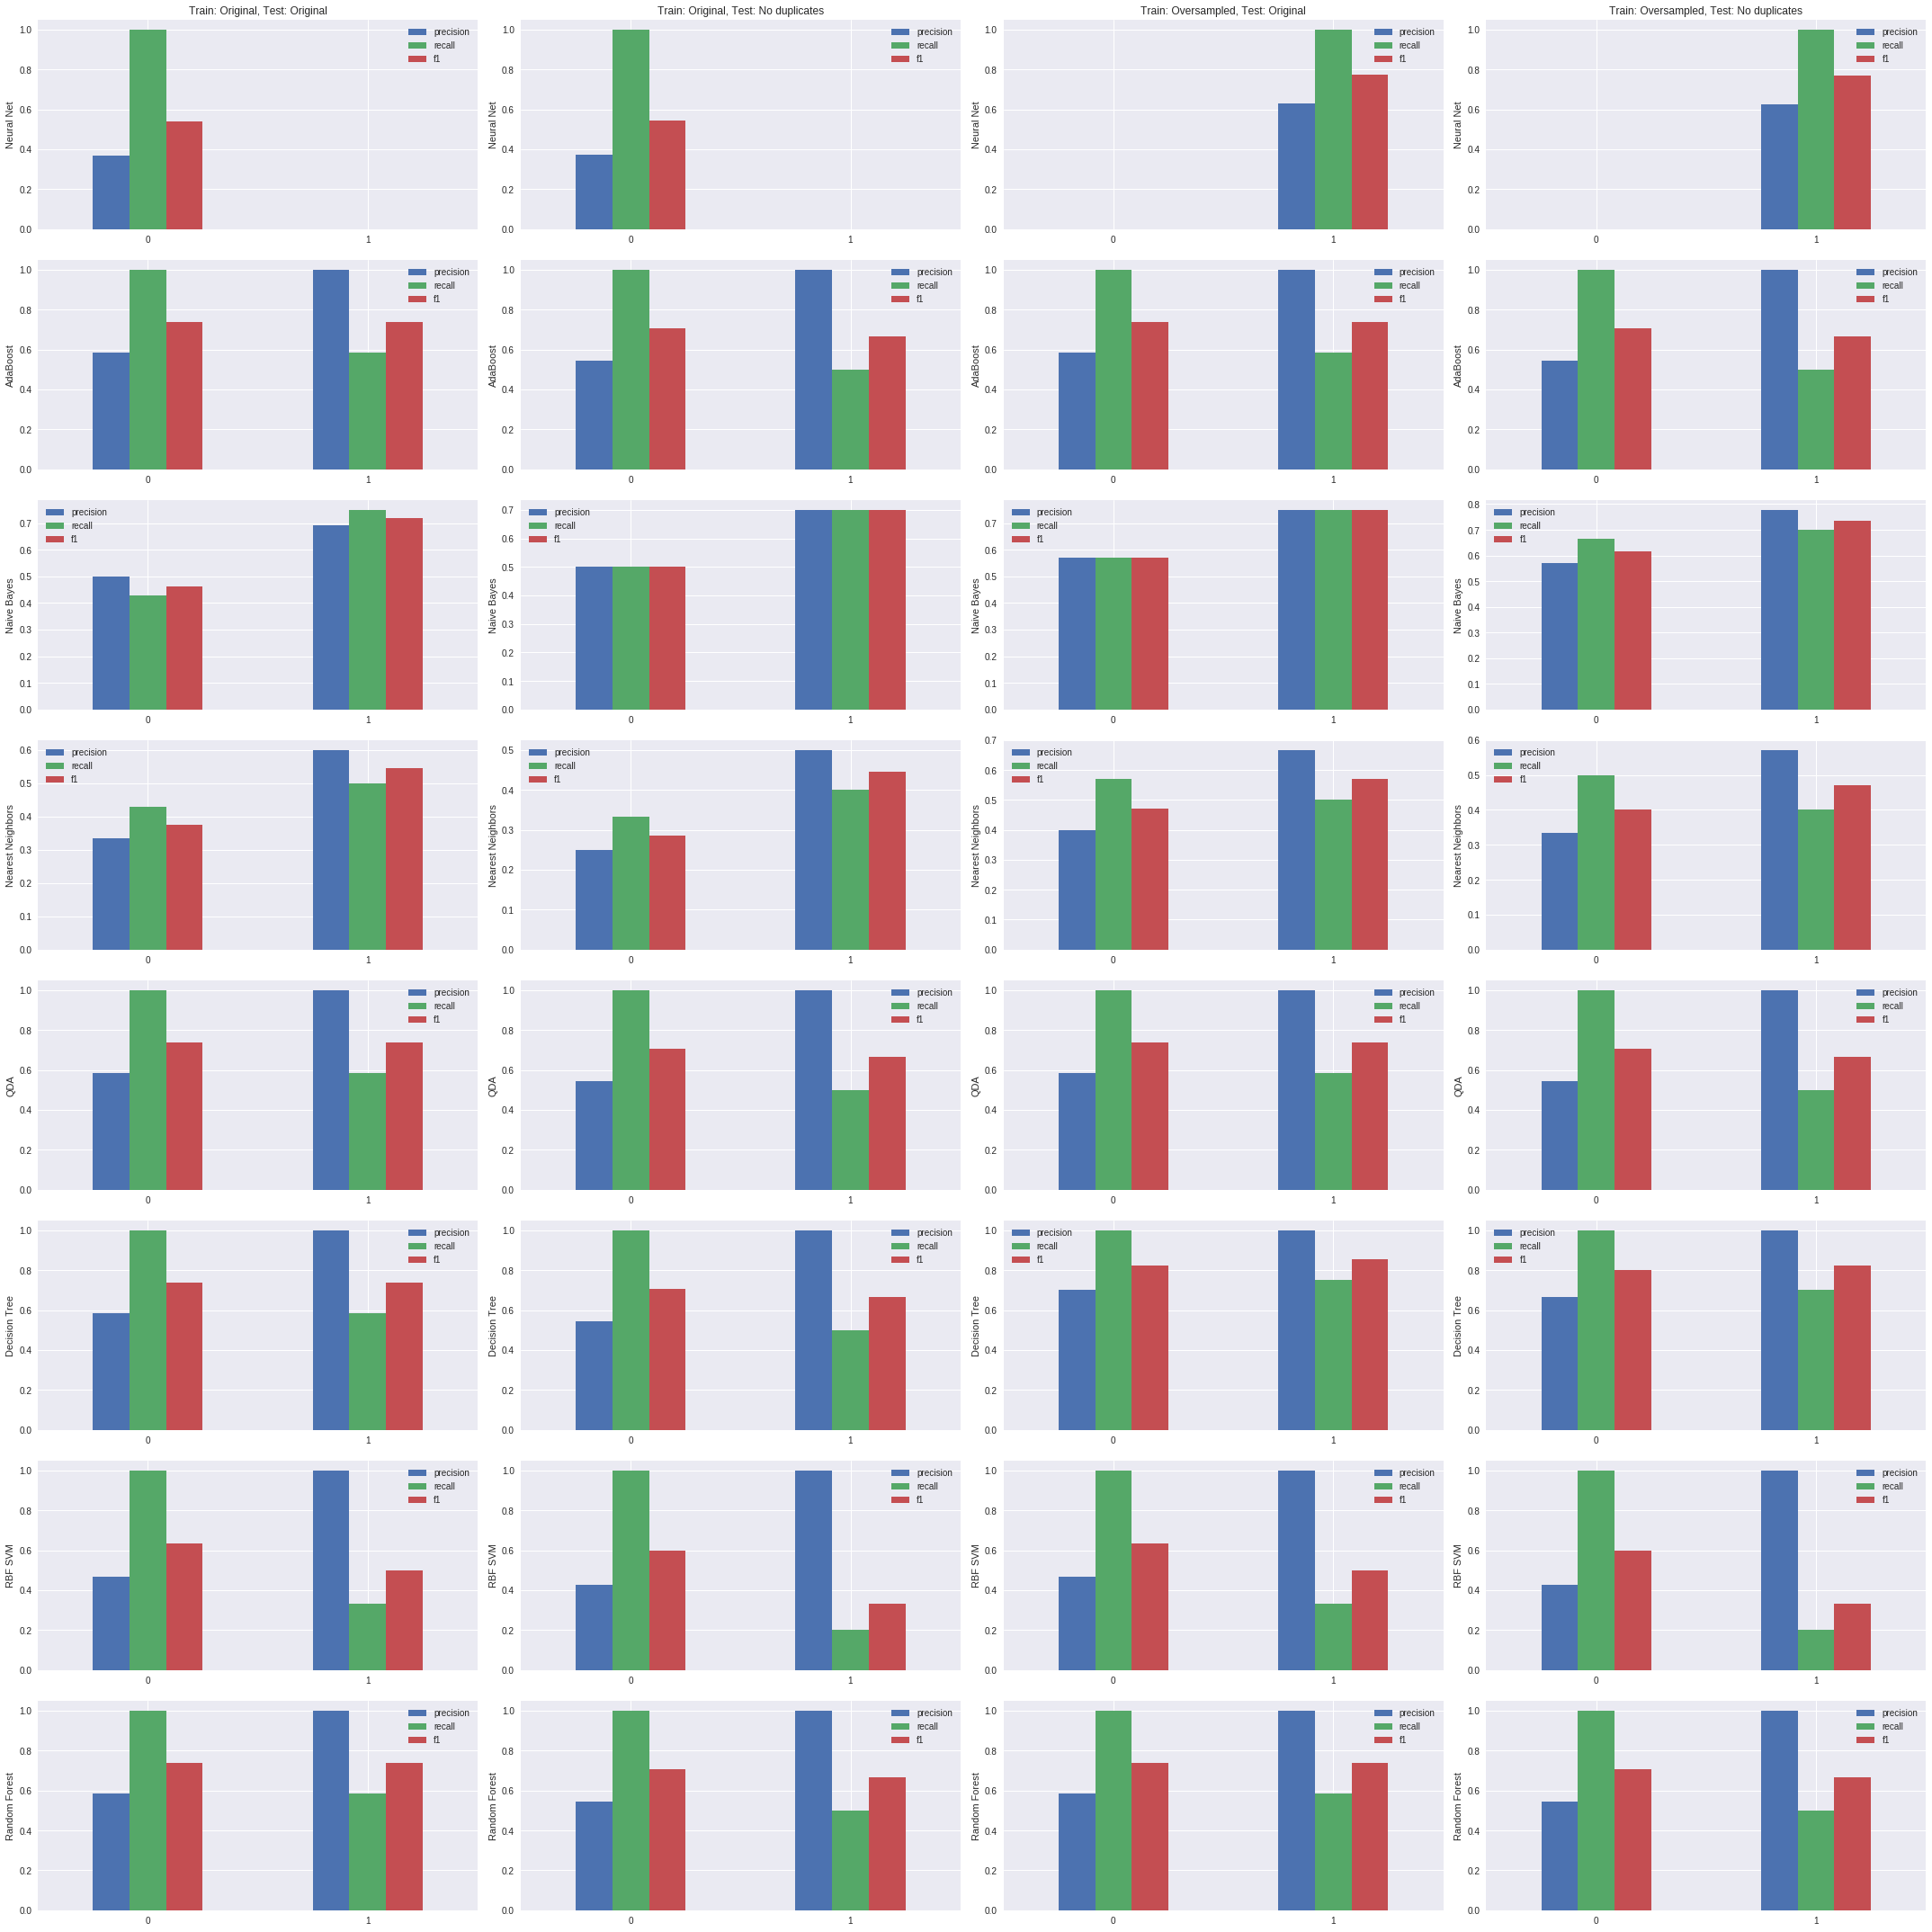

In [29]:
nrows = result_df.clf.unique().shape[0]
ncols = result_df[['train', 'test']].drop_duplicates().shape[0]

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 30))

clfs = result_df.clf.unique()
train_test_pairs = result_df[['train', 'test']].drop_duplicates().values

for i in range(nrows):
    clf = clfs[i]
    clf_results = result_df[(result_df.clf == clf)]
    for j in range(ncols):
        train_test_pair = train_test_pairs[j]
        # print(train_test_pair)
        ax = axes[i, j]
        result = clf_results[(clf_results['train']==train_test_pair[0])&
                            (clf_results['test']==train_test_pair[1])]
        # print(result)
        _ = result[['precision', 'recall', 'f1']].plot(kind='bar', ax=ax, rot=0);
        
        if i == 0:
            _ = ax.set_title('Train: {}, Test: {}'.format(train_test_pair[0], train_test_pair[1]))
        _ = ax.set_ylabel('{}'.format(clf))
        _ = ax.set_xticklabels(result['class'])
        
# plt.savefig('./classificationResult.png')
plt.tight_layout()

Having ensured that all the chosen traces all make sense we find that the predictive models are overfitting, probably due to the size of the dataset. But this also suggests that this direction is promising. In order to investigate if the predictive models are making sense, we looked at the rendered decision tree.

In [30]:
# get the original, no duplicates pair
train_ds = train_ds_list[0]
test_ds = test_ds_list[1]

train_X = train_ds.drop('class_sold', axis=1)
train_y = train_ds['class_sold']

test_X = test_ds.drop('class_sold', axis=1)
test_y = test_ds['class_sold']

ds_X = pd.concat([train_X, test_X], axis=0)
ds_y = pd.concat([train_y, test_y], axis=0)

clf = DecisionTreeClassifier(max_depth=5)
clf = clf.fit(ds_X, ds_y)

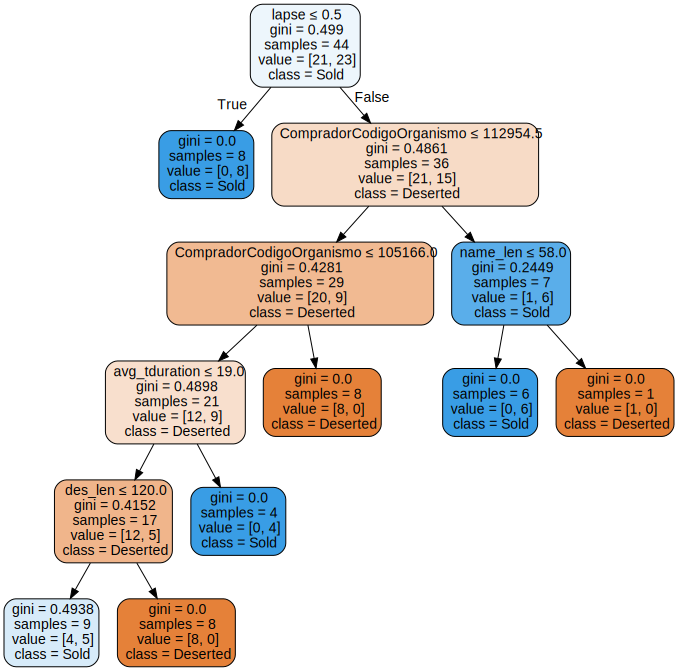

In [31]:
import graphviz
from sklearn import tree

dot_data = tree.export_graphviz(clf, out_file=None,
                               feature_names=train_X.columns,
                               class_names=['Deserted', 'Sold'],
                               filled=True, rounded=True,
                               special_characters=True)
graph = graphviz.Source(dot_data)
graph

The decision tree isn't that great due to the lack of data. Let's try it with more data.